# Project Definition

## Audience
The marketing department has requested this analysis. Data includes campaign spendings, web interactions, user demographics, product reviews so we focus on marketing insights.
<br>

## Objective
What patterns in our customers’ journeys drive spend, repeat purchases, and campaign ROI, and how can Marketing optimize touchpoints to boost revenue and retention?
<br>

## Scope
**Datasets**: Campaign logs, Customer demographics, Customer reviews, Session interactions, Purchases<br>
**Time Frame**: 5 years, March 2020 - February 2025<br>
**Exclusion**: Support tickets

# Importing

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams

import plotly.graph_objects as go

import holoviews as hv
from holoviews import opts, dim

from bokeh.plotting import save as bk_save
from bokeh.plotting import output_file as bk_output_file
from bokeh.embed import file_html
from bokeh.resources import CDN


from collections import Counter
from functools import reduce
from datetime import datetime

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
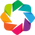

In [2]:
pd.set_option("display.max_colwidth", None)

hv.extension('bokeh')
hv.output(size=200)

In [3]:
fig_width = 7
fig_height = 4

primary = "#F5C45E" # yellow
secondary = "#E78B48" # orange
background = "#102E50" # dark blue

color1 = "#03B5AA" # green
color2 = "#F0386B" # red
color3 = "#EDC9FF" # purple
color4 = "#00CFC1" # green 2
color5 = "#F7F7FF" # white
color6 = "#F88DAD" # pink
color7 = "#40F99B" # electric green
color8 = "#C20114" # very red
color9 = "#51CB20" # very green
color10 = "#07A0C3" # blue

plot_style = [{"c": primary, "alpha": 0.8,},
              {"c": color9, "alpha": 0.8,}, 
              {"c": secondary, "alpha": 0.8,}, 
              {"c": color3, "alpha": 0.8,}]

bar_style = [{"color": secondary,"alpha": 0.8, "edgecolor": color5},
             {"color": color7,"alpha": 0.8,"edgecolor": color5}, 
             {"color": color6,"alpha": 0.8,"edgecolor": color5}, 
             {"color": color5,"alpha": 0.8,"edgecolor": color5}]

xline_style = [{"color": color2, "linestyle": "-."},
               {"color": color6, "linestyle": "-."}, 
               {"color": color10, "linestyle": "-."}, 
               {"color": color8, "linestyle": "-."}]

bbox_style = {
    "boxstyle": "square", 
    "pad":0.3, 
    "fc": "none", 
    "ec": "none", 
    "lw": 0
}

annot_style = {
    "arrowprops": {
        "arrowstyle": "-",
        "color": color1
    }, 
    "bbox": bbox_style, 
    "zorder": 0, 
    "color": secondary,
    "fontsize": 8, 
    "va": "center"
}

pie_style = {
    "wedgeprops": {
        "width":0.5
    }, 
    "startangle": -40,
}

scatter_style = [{"alpha": 0.8, "c": primary, "edgecolors": secondary, "s": 60}]

rcParams["figure.facecolor"] = background
rcParams["axes.facecolor"] = background

rcParams["figure.figsize"] = (fig_width, fig_height)
rcParams["figure.dpi"] = 120  

rcParams["axes.edgecolor"] = secondary
rcParams["axes.linewidth"] = 1.5

rcParams["grid.linestyle"] = "--"
rcParams["grid.alpha"] = 0.3
rcParams["grid.color"] = secondary

# rcParams["font.family"] = "Roboto"
rcParams["font.size"] = 12
rcParams["axes.labelsize"] = 12
rcParams["axes.titlesize"] = 14
rcParams["axes.titleweight"] = "bold"
rcParams["axes.labelcolor"] = secondary
rcParams["axes.titlecolor"] = secondary

rcParams["xtick.labelsize"] = 10
rcParams["ytick.labelsize"] = 10
rcParams["xtick.color"] = secondary
rcParams["ytick.color"] = secondary

rcParams["boxplot.boxprops.color"] = secondary
rcParams["boxplot.notch"] = False
rcParams["boxplot.boxprops.linewidth"] = 1.5
rcParams["boxplot.capprops.color"] = secondary
rcParams["boxplot.capprops.linewidth"] = 1.5
rcParams["boxplot.flierprops.markeredgecolor"] = secondary
rcParams["boxplot.flierprops.markeredgewidth"] = 1.5
rcParams["boxplot.flierprops.marker"] = "o"
rcParams["boxplot.flierprops.markersize"] = 4.0
rcParams["boxplot.meanprops.color"] = secondary
rcParams["boxplot.meanprops.linewidth"] = 1.5
rcParams["boxplot.medianprops.color"] = secondary
rcParams["boxplot.medianprops.linewidth"] = 1.5
rcParams["boxplot.whiskerprops.color"] = secondary
rcParams["boxplot.whiskerprops.linewidth"] = 1.5

rcParams["figure.autolayout"] = True

In [4]:
from os import walk

path = "../data/processed/"
filenames = next(walk(path), (None, None, []))[2]
print(filenames)

['campaigns.csv', 'customers.csv', 'customer_reviews_complete.csv', 'interactions.csv', 'support_tickets.csv', 'transactions.csv']


In [5]:
campaigns = pd.read_csv(path+"campaigns.csv")
customers = pd.read_csv(path+"customers.csv")
customer_reviews_complete = pd.read_csv(path+"customer_reviews_complete.csv")
interactions = pd.read_csv(path+"interactions.csv")
support_tickets = pd.read_csv(path+"support_tickets.csv")
transactions = pd.read_csv(path+"transactions.csv")

# Guiding Questions

## 1. Sales Efficiency
How much revenue do we get per session and per unique user?

Efficiency = Total Revenue / Total Sessions / Total Customers

In [6]:
sessions_per_user = interactions.groupby(["customer_id"])["session_id"].nunique().reset_index()

transactions_online = transactions[transactions["store_location"] == "Online"].copy()
transactions_online["amount"] = transactions_online["quantity"] * transactions_online["price"]
transactions_per_user = transactions_online.groupby(["customer_id"])["amount"].sum().reset_index()

transactions_per_session_per_user = sessions_per_user.merge(transactions_per_user, 
                                                            left_on="customer_id",
                                                            right_on="customer_id").rename(columns={"session_id": "sessions"})

sessions_per_user = None
transactions_online = None
transactions_per_user = None

In [7]:
revenue_per_session_per_user = ((transactions_per_session_per_user["amount"].sum() / 
                                 transactions_per_session_per_user["sessions"].sum()) / 
                                 transactions_per_session_per_user["customer_id"].count())

revenue_per_session_per_user

np.float64(0.07555619456865115)

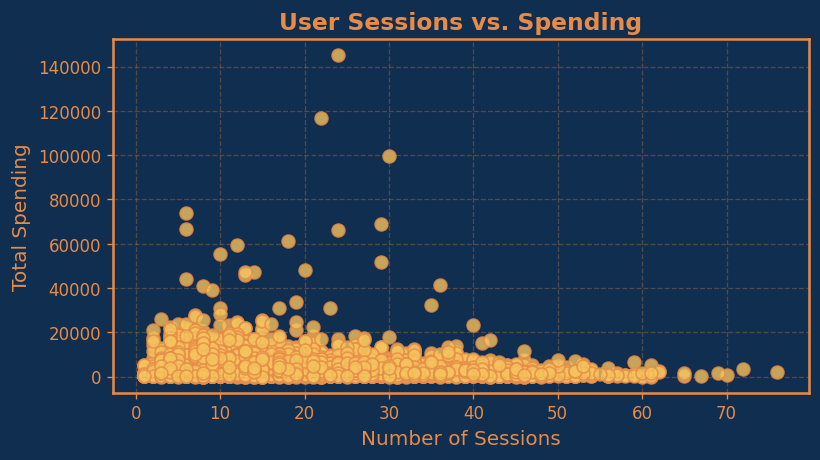

In [8]:
fig, ax = plt.subplots()

ax.scatter(transactions_per_session_per_user["sessions"], 
            transactions_per_session_per_user["amount"], 
            **scatter_style[0])

ax.set_xlabel("Number of Sessions")
ax.set_ylabel("Total Spending")
ax.set_title("User Sessions vs. Spending")
ax.grid(True)
plt.tight_layout()
plt.show()

## 2. Customer Value & Segmentation
What is each user’s lifetime value (LTV), and how do “new,” “loyal,” “one‑time,” and “churned” segments differ?

CLTV = Average Order Value × Purchase Frequency × Average Customer Lifespan<br>
Average Order Value (AOV) = Total Revenue / Total Orders<br>
Purchase Frequency (PF) = Total Orders / Unique Customers<br>
Average Customer Lifespan (ACL) = Avg time (in months or years) customers stay active

In [9]:
transactions_online = transactions[transactions["store_location"] == "Online"].copy()

transactions_online["amount"] = transactions_online["quantity"] * transactions_online["price"]
transactions_agg = transactions_online.groupby(["customer_id"]).agg(revenue=("amount", "sum"), orders=("product_name", "count"))
aov = (transactions_agg["revenue"] / transactions_agg["orders"]).reset_index().rename(columns={0: "aov"})

pf = transactions_online.groupby(["customer_id"]).agg(orders=("product_name", "count")).reset_index()

# REDUNDANT IN THIS CASE
# interactions["interaction_date"] = pd.to_datetime(interactions["interaction_date"])
# interactions_agg = interactions.groupby(["customer_id"]).agg(oldest=("interaction_date", "min"), latest=("interaction_date", "max")).reset_index().copy()
# interactions_agg["timeframe"] = interactions_agg["latest"] - interactions_agg["oldest"]
# acl = interactions_agg[["customer_id", "timeframe"]]

transactions_online = None
transactions_agg = None
interactions_agg = None

In [10]:
cltv_kpi = aov["aov"].mean() * pf["orders"].mean()
cltv_kpi

np.float64(4866.794356716076)

In [11]:
cltv = aov.merge(pf, left_on="customer_id", right_on="customer_id")
cltv["cltv"] = cltv["aov"] * cltv["orders"]
cltv = cltv.drop(columns=["aov", "orders"]).sort_values(["cltv"], ascending=False)

In [12]:
def get_bar_and_cum (cltv):
    cltv_bar = cltv.copy()
    cltv_bar["customer"] = pd.qcut(cltv_bar['cltv'], q=30, labels=False)
    cltv_bar = cltv_bar.groupby(["customer"])["cltv"].sum().reset_index().sort_values(["customer"], ascending=False)
    cltv_bar["customer"] = 30 - 1 - cltv_bar["customer"]

    cltv_cum = (cltv_bar["cltv"].cumsum() / cltv_bar["cltv"].sum()) * cltv_bar["cltv"].max()
    cltv_cum = cltv_cum.reset_index()

    return cltv_bar, cltv_cum



def plot_cltv (cltvs=[], labels=[], title="Average Order Value by Customer Segment (Quantile-Based)"):
    fig, ax = plt.subplots()

    if len(cltvs) != len(labels):
        raise IndexError("The length of cltvs and labels need to be equal.")

    for i in range(0, len(cltvs)):
        cltv = cltvs[i]
        label = labels[i]

        cltv_bar, cltv_cum = get_bar_and_cum(cltv)
        
        ax.plot(cltv_cum["cltv"], **plot_style[i])
        ax.axhline(0.8 * cltv_bar["cltv"].max(), **xline_style[i])
        ax.bar(cltv_bar["customer"], cltv_bar["cltv"], **bar_style[i], label=label)

    ax.set_xlabel("Customer Segments (Quantiles of 30)")
    ax.set_ylabel("Average Order Value")
    ax.set_title(title)
    ax.grid(True)

    legend = ax.legend(loc="center right")
    for text in legend.get_texts():
        text.set_color(secondary)

    plt.tight_layout()
    plt.show()



def plot_cltv_subplots (cltvs=[], labels=[], title="Average Order Value by Customer Segment (Quantile-Based)", sharey=False):
    if len(cltvs) != len(labels):
        raise IndexError("The length of cltvs and labels need to be equal.")
    
    if len(cltvs) < 3:
        raise IndexError("The length of cltvs must be greater than 2.")

    fig, ax = plt.subplots(int(len(cltvs) / 2), 2, sharey=sharey)

    for i in range(0, len(cltvs)):
        cltv = cltvs[i]
        label = labels[i]

        cltv_bar, cltv_cum = get_bar_and_cum(cltv)
        
        ax[int(i/2), i%2].plot(cltv_cum["cltv"], **plot_style[i])
        ax[int(i/2), i%2].axhline(0.8 * cltv_bar["cltv"].max(), **xline_style[i])
        ax[int(i/2), i%2].bar(cltv_bar["customer"], cltv_bar["cltv"], **bar_style[i], label=label)

        ax[int(i/2), i%2].set_xlabel("Customer Segments (Quantiles of 30)")
        ax[int(i/2), i%2].set_ylabel("Average Order Value")
        ax[int(i/2), i%2].grid(True)
        ax[int(i/2), i%2].tick_params(labelleft=True)

        legend = ax[int(i/2), i%2].legend(loc="center right")
        for text in legend.get_texts():
            text.set_color(secondary)

    plt.suptitle(title, 
                fontsize=plt.rcParams["axes.titlesize"],
                fontweight=plt.rcParams["axes.titleweight"],
                # fontfamily=plt.rcParams["font.family"],
                color=plt.rcParams["axes.labelcolor"])
    
    fig.set_figwidth(fig_width * 1.5)
    fig.set_figheight(fig_height * 1.5)
    plt.tight_layout()
    plt.show()

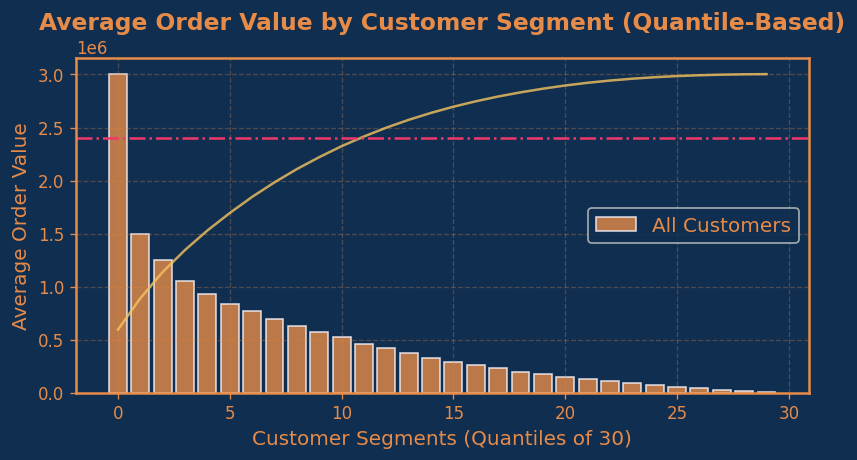

In [13]:
plot_cltv ([cltv], ["All Customers"])

For the next part of our question: “new,” “loyal,” “one‑time,” vs “churned” segments.<br>
We will first define new as "new users from last year".

In [14]:
last = pd.to_datetime(transactions["transaction_date"]).max()
last = datetime(last.year - 1, last.month, last.day)
last

datetime.datetime(2024, 2, 25, 0, 0)

In [15]:
transactions_filtered = transactions.copy()

customers_before = np.unique(transactions_filtered[pd.to_datetime(transactions_filtered["transaction_date"]) <  last]["customer_id"])
customers_after  = np.unique(transactions_filtered[pd.to_datetime(transactions_filtered["transaction_date"]) >= last]["customer_id"])

customers_new = np.setdiff1d(customers_after, customers_before)
customers_churned = np.setdiff1d(customers_before, customers_after)
customers_loyal = np.intersect1d(customers_before, customers_after)

customers_onetime = transactions_filtered.groupby(["customer_id"])["transaction_date"].count().reset_index()
customers_onetime = customers_onetime[customers_onetime["transaction_date"] == 1]
customers_onetime = customers_onetime["customer_id"].unique()

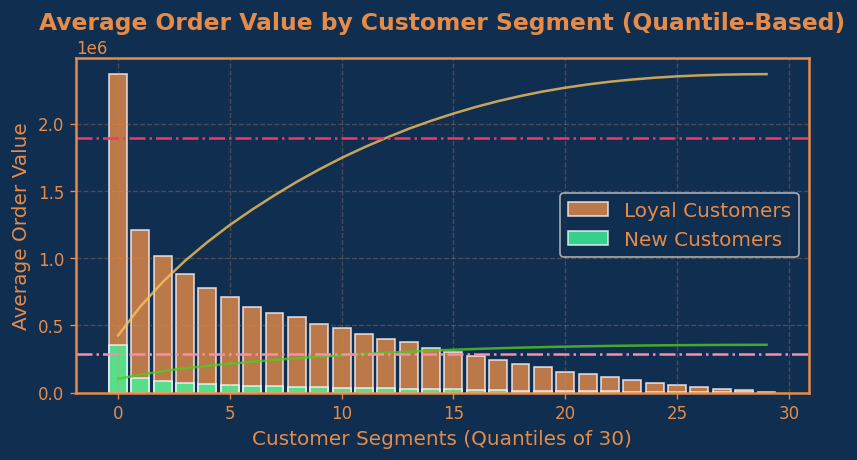

In [16]:
plot_cltv([cltv[cltv["customer_id"].isin(customers_loyal)], 
           cltv[cltv["customer_id"].isin(customers_new)]], 
          ["Loyal Customers", "New Customers"])

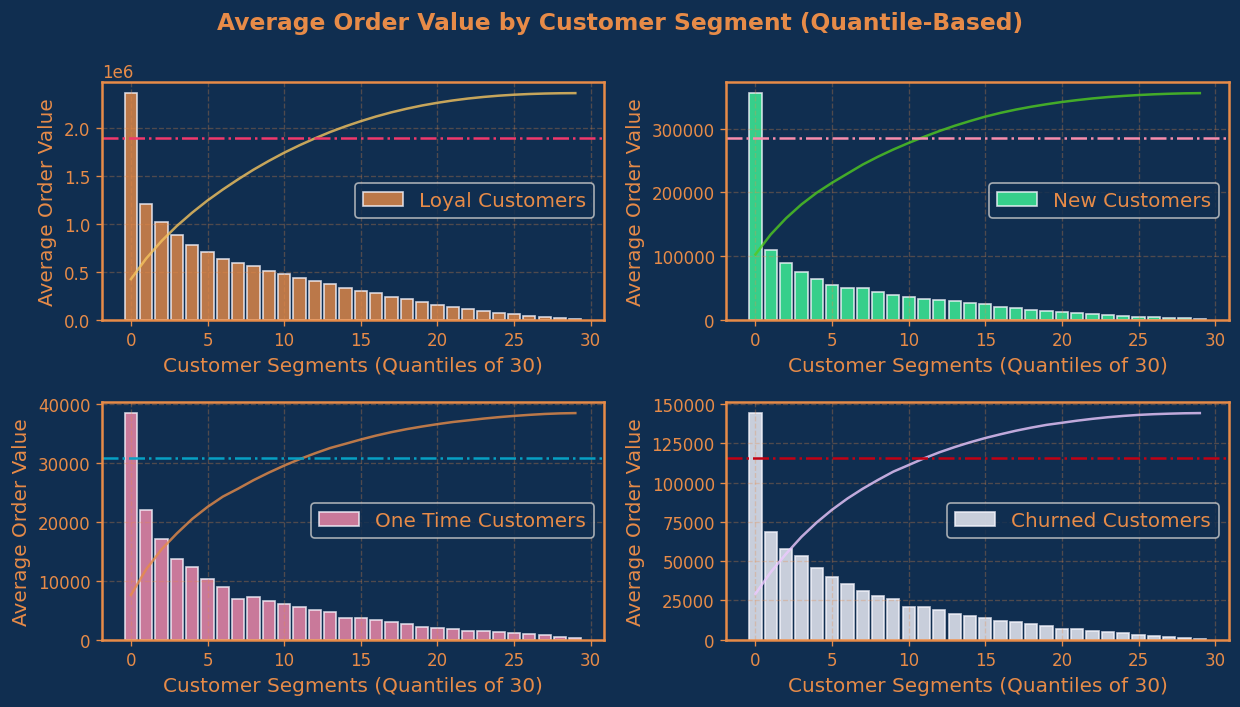

In [17]:
plot_cltv_subplots([cltv[cltv["customer_id"].isin(customers_loyal)], 
                    cltv[cltv["customer_id"].isin(customers_new)], 
                    cltv[cltv["customer_id"].isin(customers_onetime)], 
                    cltv[cltv["customer_id"].isin(customers_churned)]], 
                    ["Loyal Customers", "New Customers", "One Time Customers", "Churned Customers"])

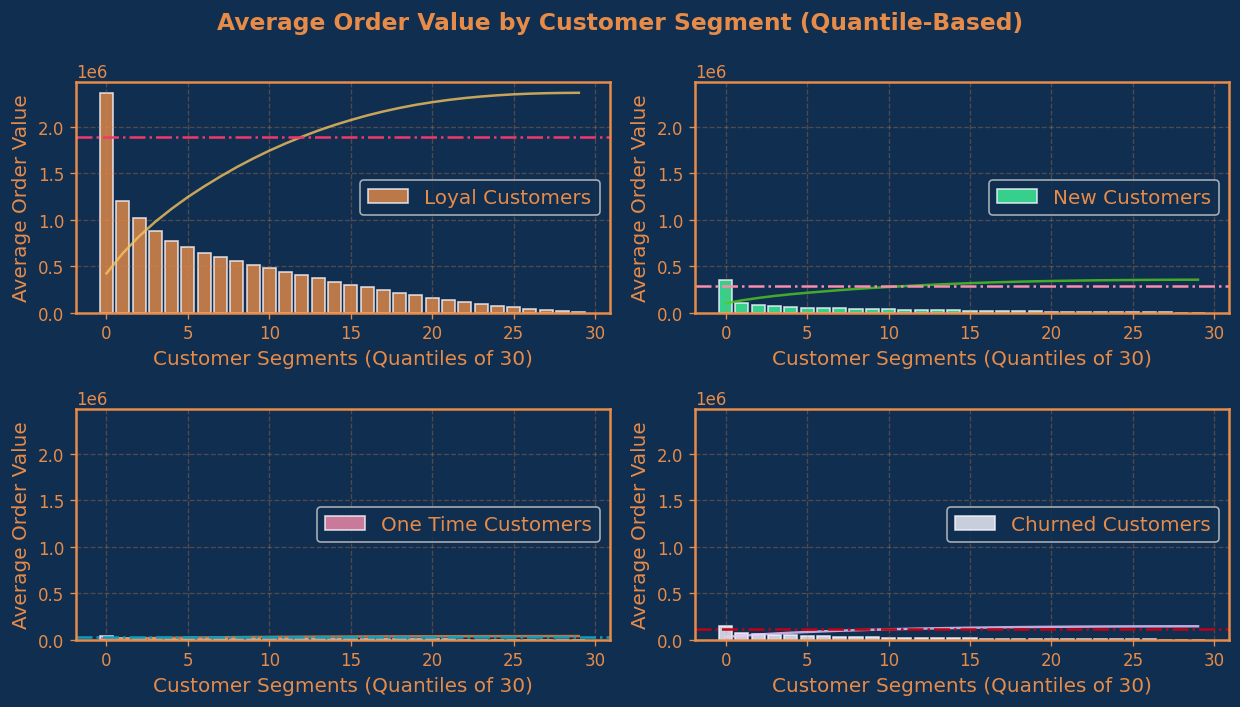

In [18]:
plot_cltv_subplots([cltv[cltv["customer_id"].isin(customers_loyal)], 
                    cltv[cltv["customer_id"].isin(customers_new)], 
                    cltv[cltv["customer_id"].isin(customers_onetime)], 
                    cltv[cltv["customer_id"].isin(customers_churned)]], 
                    ["Loyal Customers", "New Customers", "One Time Customers", "Churned Customers"], sharey=True)

## 3. Campaign Impact
Which channels deliver the highest ROI, and how much revenue is campaign‑attributed?

In [19]:
highest_roi = campaigns.groupby(["campaign_type"])["roi"].mean().reset_index().sort_values(by=["roi"], ascending=False)

In [20]:
highest_roi_kpi = highest_roi.iloc[0, 0]
highest_roi_kpi

'Search Engine Marketing'

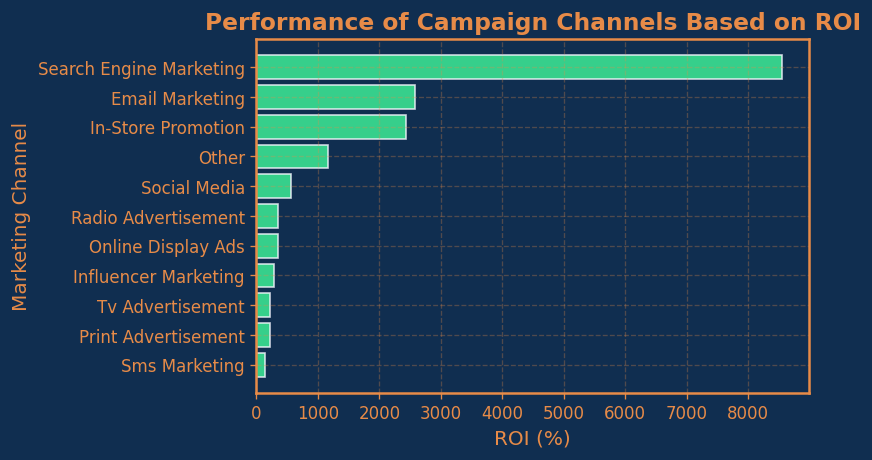

In [21]:
fig, ax = plt.subplots()

highest_roi_bar = highest_roi.sort_values(by=["roi"], ascending=True).copy()
ax.barh(highest_roi_bar["campaign_type"], highest_roi_bar["roi"], **bar_style[1])

ax.set_xlabel("ROI (%)")
ax.set_ylabel("Marketing Channel")
ax.set_title("Performance of Campaign Channels Based on ROI")
ax.grid(True)
plt.tight_layout()
plt.show()

There are two ways to estimate revenue for each campaign.<br>
1. We can just multiply ROI with budget.
2. We can get Average order value for the time duration of campaign and multiply it by conversions. We dont know which conversions lead to purchase and which lead to some other alternative like e.g signup, save to cart etc. As mentioned in the kaggle dataset description.<br>
Since we are going all in, why not use an optimizer? It basically just keeps on our calculation with different conversion rates until it hits a suitable conversion rate.

### 1. We can just multiply ROI with budget.

In [22]:
rev_est_calc = campaigns[["campaign_type", "budget", "roi"]].copy()
rev_est_calc["revenue"] = campaigns["budget"] * (1 + (campaigns["roi"] / 100))
rev_est_calc = rev_est_calc.drop(columns=["budget", "roi"]).groupby(
    ["campaign_type"]).sum().reset_index().sort_values(
    by=["revenue"], ascending=False).reset_index().drop(columns=["index"])

In [23]:
rev_est_calc["colors"] = pd.DataFrame([
    primary,
    secondary,
    color1,
    color2,
    color3,
    color4,
    color5,
    color6,
    color7,
    color8,
    background
])

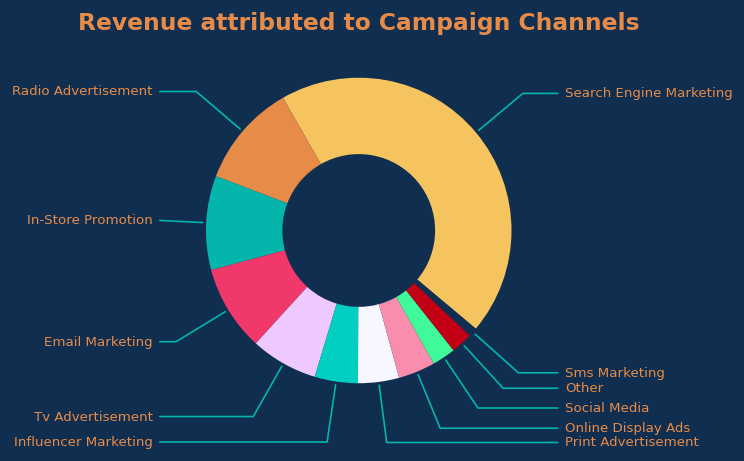

In [24]:
fig, ax = plt.subplots()

wedges, text = ax.pie(rev_est_calc["revenue"], colors=rev_est_calc["colors"], **pie_style)

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    annot_style["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(rev_est_calc["campaign_type"].iloc[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **annot_style)

ax.set_title("Revenue attributed to Campaign Channels")
ax.grid(True)
plt.tight_layout()
plt.show()

### 2. Estimating using Average order value for the time duration of campaign and multiply it by conversions.
We start with 100% conversion_purchase_rate, then until the max value of estimated campaign conversion is atmost 70% that of the total revenue, we keep decreasing the conversion_purchase_rate.
<br>
<br>
So we have assumed, that the maximum the campaign revenue can be from the total reveneu, is 70%.

In [25]:
conversion_purchase_rate = 1
campaign_revenue_threshold = 0.7

In [26]:
def get_transactions_during (start_date, end_date):
    transactions["transaction_date"] = pd.to_datetime(transactions["transaction_date"])
    transactions_filtered = transactions[["transaction_date", "quantity", "price"]].copy()
    transactions_filtered["revenue"] = transactions_filtered["quantity"] * transactions_filtered["price"]
    transactions_filtered = transactions_filtered.drop(columns=["quantity", "price"])
    transactions_filtered = transactions_filtered[
        (start_date <= transactions_filtered["transaction_date"]) & 
        (transactions_filtered["transaction_date"] < end_date)]
    return transactions_filtered["revenue"]



def optimize_conversion_purchase_rate (conversion_purchase_rate, row, threshold=campaign_revenue_threshold):
    if row["diff"] >= (1 - threshold):
        return row

    conversion_purchase_rate = conversion_purchase_rate / 2
    row["campaign_revenue"] = row["conversions"] * conversion_purchase_rate * row["aov"]
    row["diff"] = (row["total_revenue"] - row["campaign_revenue"]) / row["total_revenue"]
    return optimize_conversion_purchase_rate (conversion_purchase_rate, row)

In [27]:
campaigns_filtered = campaigns[["campaign_id", "start_date", "end_date", "conversions"]].copy()
campaigns_filtered["start_date"] = pd.to_datetime(campaigns_filtered["start_date"])
campaigns_filtered["end_date"] = pd.to_datetime(campaigns_filtered["end_date"])

revenue_during_period = campaigns_filtered
revenue_during_period["aov"] = revenue_during_period.apply(
    lambda row: get_transactions_during(
        row["start_date"], 
        row["end_date"]).mean(), axis=1
    )
revenue_during_period["total_revenue"] = revenue_during_period.apply(
    lambda row: get_transactions_during(
        row["start_date"], 
        row["end_date"]).sum(), axis=1
    )

revenue_during_period["campaign_revenue"] = revenue_during_period["conversions"] * conversion_purchase_rate * revenue_during_period["aov"]
revenue_during_period["diff"] = (revenue_during_period["total_revenue"] - revenue_during_period["campaign_revenue"]) / revenue_during_period["total_revenue"]

revenue_during_period = revenue_during_period.apply(lambda row: optimize_conversion_purchase_rate(conversion_purchase_rate,  row), axis=1)
rev_est_conv = revenue_during_period.merge(campaigns, left_on="campaign_id", right_on="campaign_id")
rev_est_conv = rev_est_conv[["campaign_type", "campaign_revenue"]]

campaigns_filtered = None
revenue_during_period = None

In [28]:
rev_est_conv = rev_est_conv.groupby(
    ["campaign_type"]).sum().reset_index().sort_values(
    by=["campaign_revenue"], ascending=False).reset_index().drop(columns=["index"])

In [29]:
rev_est_conv["colors"] = pd.DataFrame([
    primary,
    secondary,
    color1,
    color2,
    color3,
    color4,
    color5,
    color6,
    color7,
    color8,
    background
])

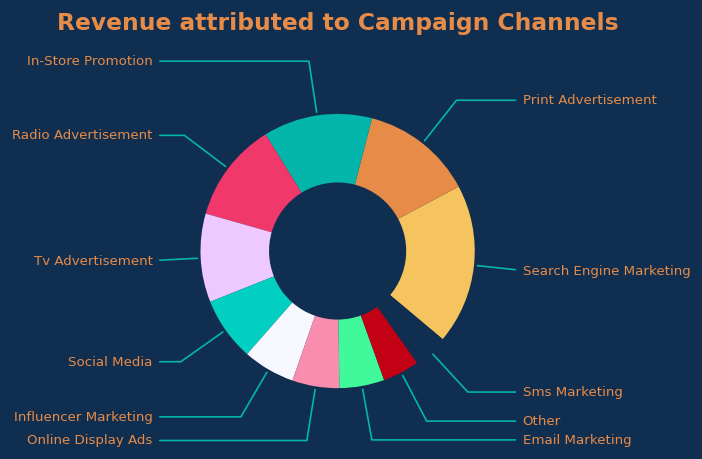

In [30]:
fig, ax = plt.subplots()

wedges, text = ax.pie(rev_est_conv["campaign_revenue"], colors=rev_est_conv["colors"], **pie_style)

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    annot_style["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(rev_est_conv["campaign_type"].iloc[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **annot_style)

ax.set_title("Revenue attributed to Campaign Channels", pad=30)
ax.grid(True)
plt.tight_layout()
plt.show()

## 4. Funnel Performance
Where are the biggest drop‑off points (view → cart → purchase) and how does session duration affect conversion?

There are many ways we can compress/aggregate the funnel data.<br>
1. Complete Customer Journey Through Select Pages.
2. Unique Customer Journey Through Select Pages.
3. Unique Customer Journey Through All Pages.
4. Visit Count For Each Page.
<br>
<br>

It does not stop here. We can.<br>
1. Do above for each user (aggregate sessions).
2. Do above for each session.

In [31]:
path_log = "../log/"
path_plot = "../plots/"
important_pages = ["Wishlist_Add", "Add_To_Cart", "Checkout", "Other", "Page_View", "Product_View", "Purchase", "Search", "Leave"]
important_pages_colors = [primary, secondary, color7, color2, color3, color4, color5, color6, color8]
all_pages = interactions["interaction_type"].unique().tolist()

In [32]:
def get_set (items):
    _, idx = np.unique(items, return_index=True)
    return np.array(items)[idx]



def filter_set(items, criteria):
    items = np.array(items)
    mask = np.isin(items, criteria)
    return np.where(mask, items, "Other")



def get_last (my_list):
    if isinstance(my_list, list):
        last_el = my_list[-1]
        return get_last(last_el)
    else:
        return my_list
    


def get_interaction_combination (outer_list, new_el):
    last_el = get_last(outer_list)
    new_list = [last_el, new_el]

    if isinstance(outer_list, list):
        if isinstance(outer_list[-1], list):
            return [*outer_list, new_list]
        else:
            return [outer_list, new_list]
        
    return [new_list]



def get_interaction_combinations (df):
    df = df["interaction_type"].apply(lambda x: reduce(get_interaction_combination, x))
    all_interactions = [(sub_list[0], sub_list[1]) for row in df for sub_list in row]
    count_interactions = Counter(all_interactions).items()
    return count_interactions



def get_sankey (df, criteria):
    count_interactions = get_interaction_combinations(df)
    source = []
    target = []
    value = []
    for count in count_interactions:
        source.append(criteria.index(count[0][0]))
        target.append(criteria.index(count[0][1]))
        value.append(count[1])
    return source, target, value



def hex_to_rgba(hex_color, alpha=0.7):
    hex_color = hex_color.lstrip("#")
    r, g, b = [int(hex_color[i:i+2], 16) for i in (0, 2, 4)]
    return f"rgba({r}, {g}, {b}, {alpha})"



def plot_sankey (df, criteria, criteria_colors, title="Customer Journey"):
    source, target, value = get_sankey(df, criteria)

    fig_props = {
        "paper_bgcolor": background,
        "font_size": 14
    }

    title_props = {
        "text": title,
        "x": 0.5, 
        "xanchor": "center", 
        "font": {
            "size": 30,
            "color": primary
        }
    }

    source_colors_hex = [criteria_colors[ind] for ind in source]
    source_colors_rgba = [hex_to_rgba(hex) for hex in source_colors_hex]

    fig = go.Figure(data=[go.Sankey(
        node = {
            "pad": 15,
            "thickness": 20,
            "line": {
                "color": "black",
                "width": 0.5
            },
            "label": criteria,
            "color": criteria_colors
        },
        link = {
            "arrowlen": 10,
            "source": source,
            "target": target,
            "value": value,
            "color": source_colors_rgba
    })])

    fig.update_layout(title=title_props, **fig_props)
    html = fig.to_html(full_html=True)
    html = html.replace("<head>", f"<head><style>body {{ margin: 0; background-color: {background}; }}</style>")

    file_name = path_plot+"Sankey/"+title.replace(" ", "_")+".html"
    with open(file_name, "w", encoding="utf-8") as file:
        file.write(html)


def plot_chord (journey, criteria, title):
    chord_style = {
        "bgcolor": background,
        "label_text_font_size": '10pt',
        "label_text_color": secondary,
        "height": 400,
        "width": 400,
    }

    source, target, value = get_sankey(journey, criteria)
    links = pd.DataFrame({"source": source, "target": target, "value": value})
    nodes = hv.Dataset(pd.DataFrame(criteria, columns=["product"]), 'index')

    chord = hv.Chord((links, nodes)).select(value=(5, None))
    ch = chord.opts(
        opts.Chord(title=title, cmap='Category20', edge_cmap='Category20', edge_color=dim('source').str(), 
                labels='product', node_color=dim('index').str(), **chord_style))

    bokeh_fig = hv.render(ch, backend='bokeh')

    bokeh_fig.title.text_color = secondary
    bokeh_fig.title.text_font_size = "18pt"
    bokeh_fig.title.align = 'center'
    bokeh_fig.border_fill_color = background
    bokeh_fig.background_fill_color = background

    html = file_html(bokeh_fig, CDN, "My Chord Visual")
    html = html.replace("</head>", f"""<style>body {{ 
                        background-color: {background};
                        margin: 0;
                        padding: 0;
                        display: flex;
                        justify-content: center;
                        align-items: center;
                        height: 100vh;  }}</style></head>""")
    
    file_name = path_plot+"Chord/"+title.replace(" ", "_")+".html"
    with open(file_name, "w") as file:
        file.write(html)

In [33]:
interactions_filtered = interactions[interactions["channel"].isin(["Web", "Mobile App"])].copy()
interactions_filtered["interaction_date"] = pd.to_datetime(interactions_filtered["interaction_date"])
interactions_filtered = interactions_filtered.sort_values(by=["customer_id", "session_id", "interaction_date"])

### 1. Complete Customer Journey Through Select Pages

#### 1. For each user

In [34]:
journey = interactions_filtered.groupby(by=["customer_id"])["interaction_type"].agg(list).reset_index()
journey["interaction_type"] = journey["interaction_type"].apply(lambda items: filter_set(items, important_pages))
journey["interaction_type"] = journey["interaction_type"].apply(lambda x: np.append(x, "Leave"))

pages_visited = journey["interaction_type"].apply(lambda items: len(items)).value_counts().reset_index().sort_values(by=["interaction_type"])
pages_visited.columns = ["pages", "users"]

plot_sankey(journey, important_pages, important_pages_colors, title="Complete Customer Journey Through Select Pages")

#### 2. For each session

In [35]:
journey = interactions_filtered.groupby(by=["session_id"])["interaction_type"].agg(list).reset_index()
journey["interaction_type"] = journey["interaction_type"].apply(lambda items: filter_set(items, important_pages))
journey["interaction_type"] = journey["interaction_type"].apply(lambda x: np.append(x, "Leave"))

pages_visited = journey["interaction_type"].apply(lambda items: len(items)).value_counts().reset_index().sort_values(by=["interaction_type"])
pages_visited.columns = ["pages", "users"]

plot_sankey(journey, important_pages, important_pages_colors, title="Complete Session Journey Through Select Pages")

### 2. Unique Customer Journey Through Select Pages
#### 1. For each user

In [36]:
journey = interactions_filtered.groupby(by=["customer_id"])["interaction_type"].agg(list).reset_index()
journey["interaction_type"] = journey["interaction_type"].apply(lambda items: get_set(items)).apply(lambda items: filter_set(items, important_pages))
journey["interaction_type"] = journey["interaction_type"].apply(lambda x: np.append(x, "Leave"))

pages_visited = journey["interaction_type"].apply(lambda items: len(items)).value_counts().reset_index().sort_values(by=["interaction_type"])
pages_visited.columns = ["pages", "users"]

plot_sankey(journey, important_pages, important_pages_colors, title="Unique Customer Journey Through Select Pages")

#### 2. For each session

In [37]:
journey = interactions_filtered.groupby(by=["session_id"])["interaction_type"].agg(list).reset_index()
journey["interaction_type"] = journey["interaction_type"].apply(lambda items: get_set(items)).apply(lambda items: filter_set(items, important_pages))
journey["interaction_type"] = journey["interaction_type"].apply(lambda x: np.append(x, "Leave") if len(x) == 1 else x)

pages_visited = journey["interaction_type"].apply(lambda items: len(items)).value_counts().reset_index().sort_values(by=["interaction_type"])
pages_visited.columns = ["pages", "sessions"]

plot_sankey(journey, important_pages, important_pages_colors, title="Unique Session Journey Through Select Pages")

### 3. Unique Customer Journey Through All Pages
#### 1. For each user

In [38]:
all_pages.append("Leave")

all_pages_colors = [
    primary,
    secondary,
    color1,
    color2,
    color3,
    color4,
    color5,
    color6,
    color8,
    color7,
    color9,
    color10,
    primary,
    secondary,
    color1,
    color2,
    color3
]

In [39]:
journey = interactions_filtered.groupby(by=["customer_id"])["interaction_type"].agg(list).reset_index()
journey["interaction_type"] = journey["interaction_type"].apply(lambda items: get_set(items))
journey["interaction_type"] = journey["interaction_type"].apply(lambda x: np.append(x, "Leave") if len(x) == 1 else x)

pages_visited = journey["interaction_type"].apply(lambda items: len(items)).value_counts().reset_index().sort_values(by=["interaction_type"])
pages_visited.columns = ["pages", "users"]

plot_chord(journey, all_pages, "Unique Customer Journey Through All Pages")

#### 2. For each session

In [40]:
journey = interactions_filtered.groupby(by=["session_id"])["interaction_type"].agg(list).reset_index()
journey["interaction_type"] = journey["interaction_type"].apply(lambda items: get_set(items))
journey["interaction_type"] = journey["interaction_type"].apply(lambda x: np.append(x, "Leave") if len(x) == 1 else x)

pages_visited = journey["interaction_type"].apply(lambda items: len(items)).value_counts().reset_index().sort_values(by=["interaction_type"])
pages_visited.columns = ["pages", "sessions"]

plot_chord(journey, all_pages, "Unique Session Journey Through All Pages")

### 4. Visit Count For Each Page
#### 1. For each user

In [41]:
all_pages_colors = [
    primary,
    color1,
    color2,
    color3,
    color4,
    color5,
    color6,
    color8,
    color7,
    color9,
    color10,
]

In [42]:
def plot_box (data, labels, colors):
    num_boxes = len(data)

    fig, ax = plt.subplots(figsize=(10, 6))

    bp = ax.boxplot(data, notch=False, orientation='vertical', whis=1.5)
    medians = bp["medians"]
    medians = [median.get_ydata()[0] for median in medians]

    pos = np.arange(num_boxes) + 1
    upper_labels = [str(round(s, 2)) for s in medians]
    for i in range(num_boxes):
        ax.text(pos[i], .95, upper_labels[i], transform=ax.get_xaxis_transform(),
                horizontalalignment='center', size='medium', weight="bold", color=colors[i])
        
    for box, color in zip(bp['boxes'], colors):
        box.set(color=color)

    ax.set_xticklabels(labels, rotation=45)
    max_y = np.max([np.max(m) for m in data])
    ax.set_ylim(0, int(max_y * 1.2)) 

    plt.show()

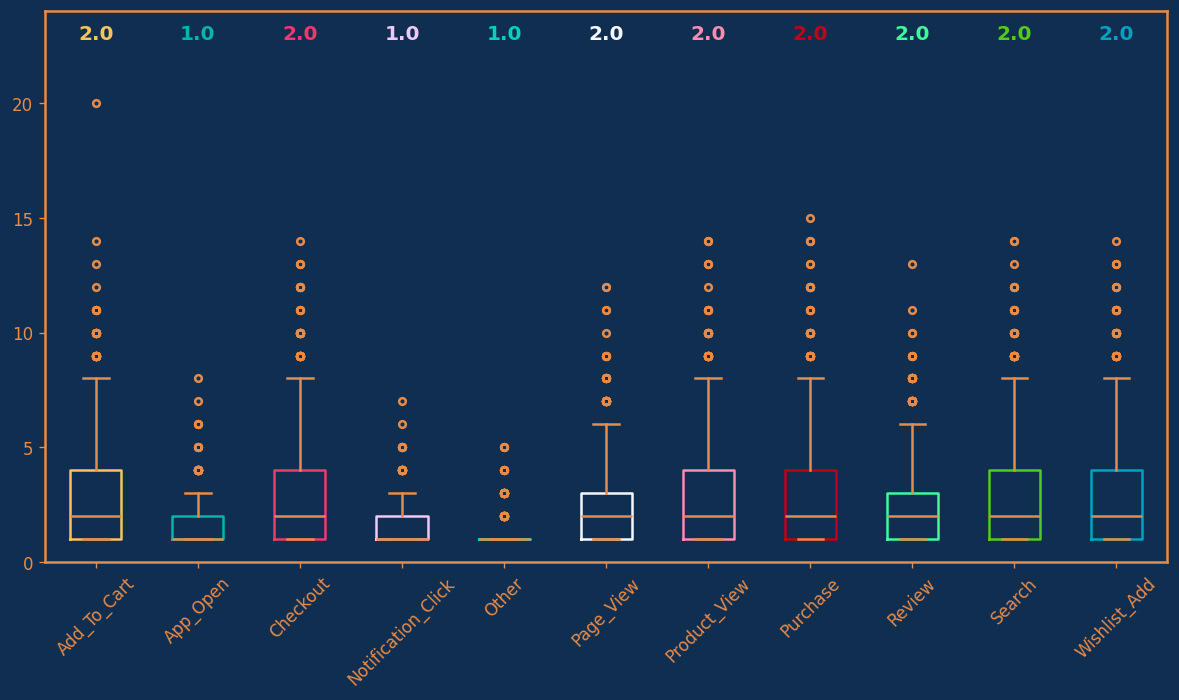

In [43]:
journey = interactions_filtered.groupby(by=["customer_id", "interaction_type"])["interaction_id"].count().reset_index().rename(
    columns={"interaction_id": "count"}).sort_values(by=["interaction_type"]).drop(columns=["customer_id"])
journey_unique_page = journey["interaction_type"].unique()
journey_lists = [journey[journey["interaction_type"] == page]["count"] for page in journey_unique_page]

plot_box(journey_lists, journey_unique_page, all_pages_colors)

#### 2. For each session

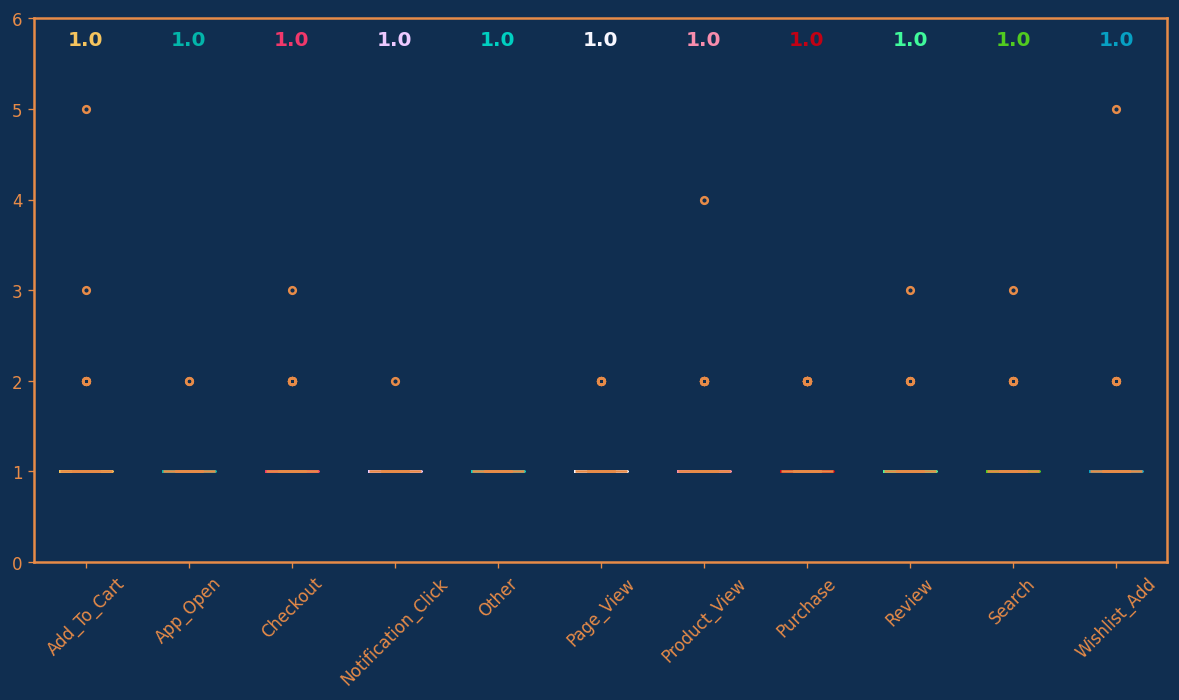

In [44]:
journey = interactions_filtered.groupby(by=["session_id", "interaction_type"])["interaction_id"].count().reset_index().rename(
    columns={"interaction_id": "count"}).sort_values(by=["interaction_type"]).drop(columns=["session_id"])
journey_unique_page = journey["interaction_type"].unique()
journey_lists = [journey[journey["interaction_type"] == page]["count"] for page in journey_unique_page]

plot_box(journey_lists, journey_unique_page, all_pages_colors)

In [45]:
interactions_filtered = None
journey = None
pages_visited = None

## 5. Product & Timing Insights
Which products are often a customer’s first purchase, which are trending or declining, and what day/hour windows maximize campaign conversion?

Let's get the first purchases.

In [46]:
top_10_colors = [
    color1,
    color2,
    color3,
    color4,
    color5,
    color6,
    color8,
    color7,
    color9,
    color10
]

In [47]:
def plot_bar (df, label_col, val_col, colors, title, label_y, upper_labels=True):
    fig, ax = plt.subplots()

    bars = ax.bar(df[label_col], df[val_col], color=colors, edgecolor=primary, linewidth=2)

    if upper_labels:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height}', 
                    ha='center', va='bottom', weight="bold", fontsize=10, color=primary)

    ax.set_ylabel(label_y)
    ax.set_title(title)

    ax.set_xticks(df[label_col])
    ax.set_xticklabels(df[label_col], rotation=45)

    max_y = df[val_col].max()
    min_y = df[val_col].min()
    ax.set_ylim(min_y - (min_y*0.2), (max_y * 1.2))

    plt.show()

In [48]:
transactions["transactiondate"] = pd.to_datetime(transactions["transaction_date"])

transactions_filtered = transactions.groupby(by=["customer_id"])["transaction_date"].idxmax()
first_purchase = transactions.loc[transactions_filtered].reset_index(drop=True)

transactions_filtered = None

This is an alternative approach.

In [49]:
# transactions_filtered = transactions.copy()
# transactions_filtered["rank"] = transactions_filtered.groupby('customer_id')['transaction_date'].rank(method='first')
# first_purchase = transactions_filtered[transactions_filtered["rank"] == 1].drop(columns=["rank"]).reset_index(drop=True)

Below is a faulty approach, because we will get multiple first purchases for same day.

In [50]:
# transactions_filtered = transactions.groupby(by=["customer_id"])["transaction_date"].min().reset_index()
# first_purchase = transactions.merge(transactions_filtered, 
#                                        left_on=["customer_id", "transaction_date"], 
#                                        right_on=["customer_id", "transaction_date"], 
#                                        how="inner")

In [51]:
first_purchase_count = first_purchase.groupby(by=["product_name"])["customer_id"].count().reset_index()
first_purchase_count = first_purchase_count.rename(columns={"customer_id": "freq"}).sort_values(by=["freq"], ascending=False).reset_index(drop=True)

first_purchase = None

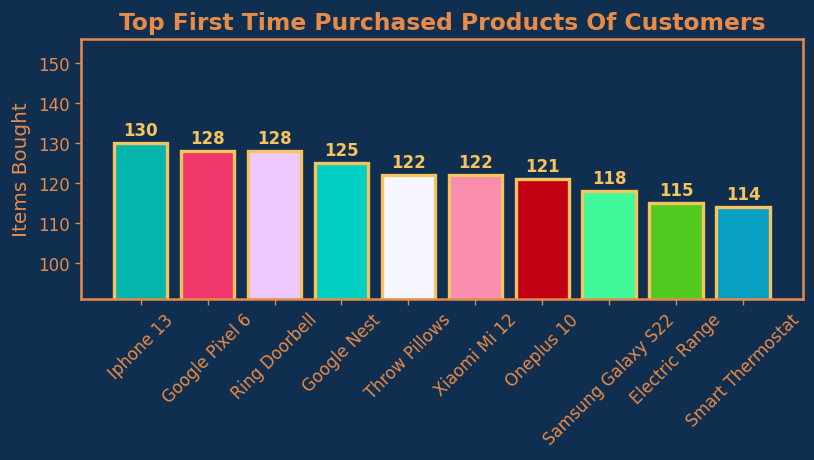

In [52]:
# Bar Plot of top 10
plot_bar (first_purchase_count[:10], "product_name", "freq", top_10_colors, "Top First Time Purchased Products Of Customers", "Items Bought")

Let's get trending and declining products over months.

In [53]:
transactions["transaction_date"] = pd.to_datetime(transactions["transaction_date"])
transactions_filtered = transactions.copy()
transactions_filtered["year"] = transactions_filtered["transaction_date"].dt.year
transactions_filtered["month"] = transactions_filtered["transaction_date"].dt.month

product_counts = transactions_filtered.groupby(by=["product_name", "year", "month"])["quantity"].sum().reset_index()
product_counts = product_counts.sort_values(by=["product_name", "year", "month"])

product_counts["month"] = product_counts["month"].apply(lambda i: "0"+str(i) if i < 10 else str(i))
product_counts["date"] = product_counts["year"].astype(str) + "-" + product_counts["month"] + "-01"
product_counts["date"] = pd.to_datetime(product_counts["date"])
product_counts = product_counts.drop(columns=["year", "month"])

product_counts["diff"] = product_counts.groupby(by=["product_name"])["quantity"].diff()
product_counts = product_counts.groupby(by=["product_name"])["diff"].mean().reset_index().sort_values(by=["diff"], ascending=False)

transactions_filtered = None

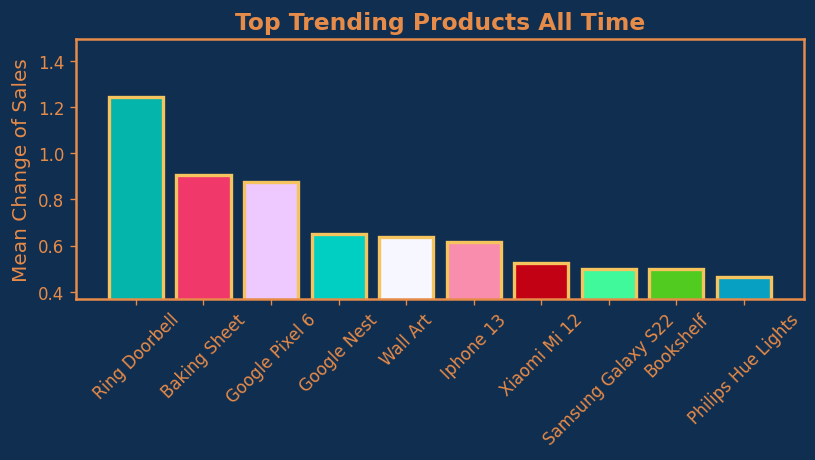

In [54]:
# Bar Plot Top 10 Trends
plot_bar (product_counts[:10], "product_name", "diff", top_10_colors, "Top Trending Products All Time", "Mean Change of Sales", False)

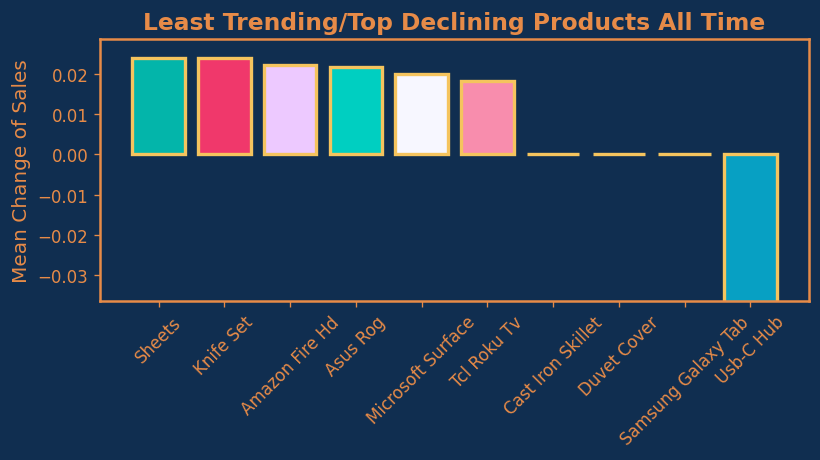

In [55]:
# Bar Plot Least 10 Trending/Declining
plot_bar (product_counts[-10:], "product_name", "diff", top_10_colors, "Least Trending/Top Declining Products All Time", "Mean Change of Sales", False)

Time windows for best performing campaigns.

In [56]:
campaigns["start_date"] = pd.to_datetime(campaigns["start_date"])
campaigns["end_date"] = pd.to_datetime(campaigns["end_date"])

start_date = campaigns["start_date"].min()
end_date = campaigns["end_date"].max()

timeline = pd.DataFrame(pd.date_range(start=start_date, end=end_date), columns=["date"])

In [57]:
timeline["key"] = 1
campaigns_copy = campaigns.copy()
campaigns_copy["key"] = 1
timeline = timeline.merge(campaigns_copy, on="key").drop(columns="key")

timeline = timeline[(timeline["start_date"] <= timeline["date"]) & (timeline["end_date"] >= timeline["date"])]
timeline = timeline.groupby(by=["date"])["roi"].agg(["min", "max", "mean", "count"]).reset_index()

# Basic Normalization, yes I know it hides e.g email marketing vs other channels timeperiods are now mixed.
timeline["min"] = timeline["min"] / timeline["count"]
timeline["max"] = timeline["max"] / timeline["count"]
timeline["mean"] = timeline["mean"] / timeline["count"]
timeline

campaigns_copy = None

Alternative way, but slower.

In [58]:
# timeline_agg = timeline["date"].apply(
#     lambda date: 
#     campaigns[(campaigns["start_date"] <= date) & (campaigns["end_date"] >= date)]["roi"].agg(["min", "max", "mean", "count"])
# ).reset_index()

# timeline = timeline.merge(timeline_agg, left_index=True, right_on="index").drop(columns=["index"])

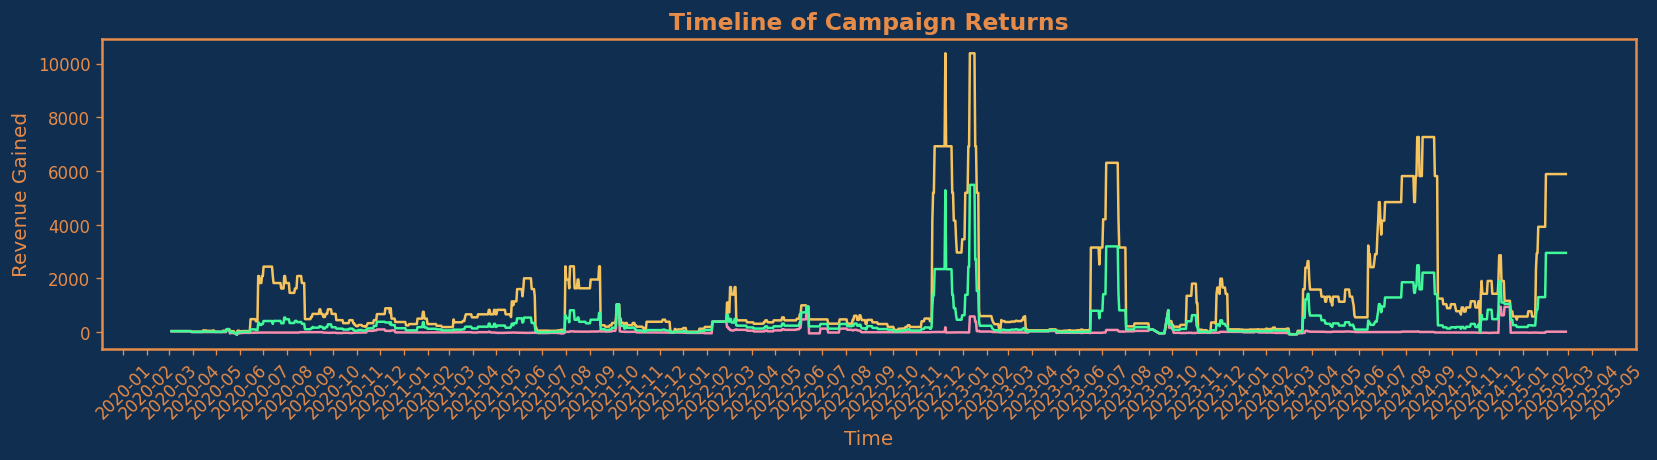

In [59]:
# Multi-Line Plot
from matplotlib.dates import MonthLocator
fig, ax = plt.subplots()

ax.plot(timeline["date"], timeline["max"], linewidth=1.5, color=primary)
ax.plot(timeline["date"], timeline["min"], linewidth=1.5, color=color6)
ax.plot(timeline["date"], timeline["mean"], linewidth=1.5, color=color7)

ax.set_title("Timeline of Campaign Returns")
ax.set_xlabel("Time")
ax.set_ylabel("Revenue Gained")

ax.xaxis.set_major_locator(MonthLocator())
plt.xticks(rotation=45)

fig.set_figwidth(fig_width*2)

plt.show()

## 6. Pain Points & Issues
Which products see the highest cart abandonment, what share of sessions bounce, and what are the top support‑ticket categories?

Cart abandonments.

In [60]:
cart = interactions[interactions["interaction_type"].isin(["Add_To_Cart"])]["page_or_product"].value_counts().reset_index().rename(columns={"count": "cart"})
purchase = transactions[transactions["store_location"] == "Online"]["product_name"].value_counts().reset_index().rename(columns={"count": "purchase"})

cart_abandoned = purchase.merge(cart, left_on="product_name", right_on="page_or_product").drop(columns=["page_or_product"])
cart_abandoned["abandoned"] = (cart_abandoned["cart"] - cart_abandoned["purchase"]) / cart_abandoned["cart"]
cart_abandoned = cart_abandoned.sort_values(by=["abandoned"], ascending=False).reset_index(drop=True)

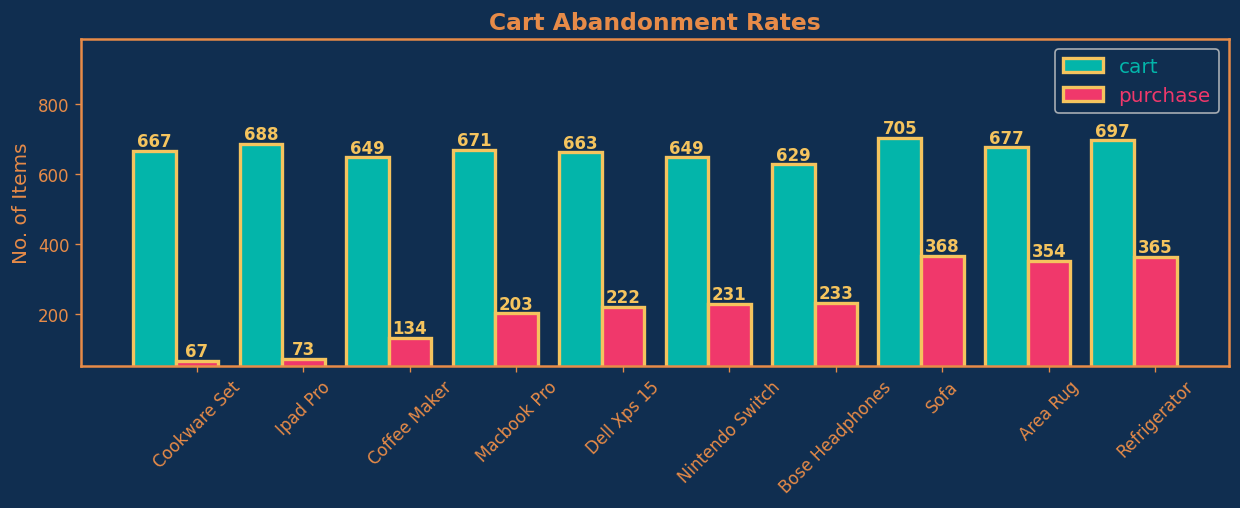

In [61]:
# Add (Add to Cart) Rates, so we get two bars in place of one
# Add to cart vs abandonment rate
# Bar Chart Top 10

def plot_grouped_bar (df, label_col, val_cols, colors, title, label_y):
    fig, ax = plt.subplots()

    x = np.arange(df[label_col].shape[0])
    width = 0.4
    multiplier = 0

    for val_col in val_cols:
        offset = width * multiplier
        bars = ax.bar(x + offset, df[val_col], width=width, color=colors[multiplier], edgecolor=primary, linewidth=2)
        multiplier += 1

        ax.set_xticks(x+width, df[label_col])
        ax.set_xticklabels(df[label_col], rotation=45)

        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height}', 
                    ha='center', va='bottom', weight="bold", fontsize=10, color=primary)

    max_y = np.max([df[val_col].max() for val_col in val_cols])
    min_y = np.min([df[val_col].min() for val_col in val_cols])
    ax.set_ylim(min_y - (min_y*0.2), int(max_y * 1.4))

    ax.set_ylabel(label_y)
    ax.set_title(title)

    ax.legend(val_cols, loc="upper right", labelcolor="linecolor")

    fig.set_figwidth(fig_width*1.5)
    fig.set_figheight(fig_height*1.1)
    plt.show()

plot_grouped_bar(cart_abandoned[:10], "product_name", ["cart", "purchase"], top_10_colors, "Cart Abandonment Rates", "No. of Items")

Session bounce (sessions with only 1 interaction).

In [62]:
session_count = interactions.groupby(by=["session_id"])["interaction_type"].count().reset_index().rename(columns={"interaction_type": "interaction_count"})
session_count = (session_count["interaction_count"] == 1).value_counts().reset_index()
users_bounced = session_count[session_count["interaction_count"] == True]["count"].values
users_journey = session_count[session_count["interaction_count"] == False]["count"].values

bounce_rate = users_bounced / (users_bounced + users_journey)
bounce_rate

array([0.99389581])

Top support‑ticket categories.

In [63]:
support_categories = support_tickets["issue_category"].value_counts().reset_index().sort_values(by=["count"], ascending=False)

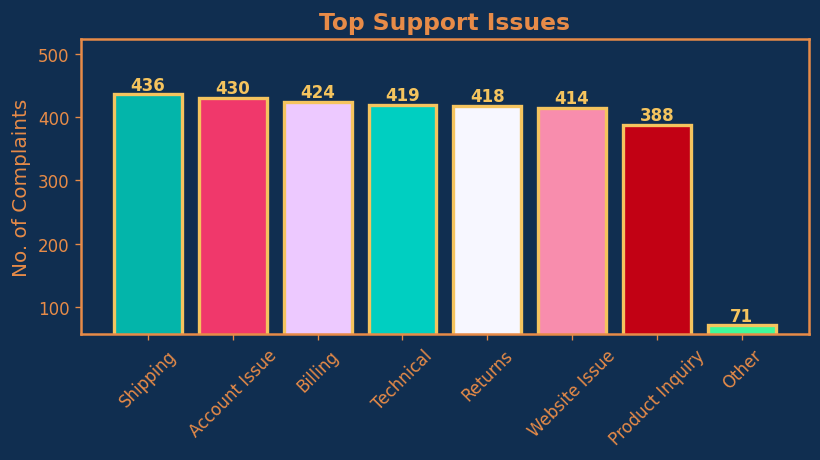

In [65]:
# Bar Chart Top 10
plot_bar(support_categories, "issue_category", "count", top_10_colors[:support_categories.shape[0]], "Top Support Issues", "No. of Complaints")